In [1]:
import networkx as nx
from hierarchy_pos import hierarchy_pos
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np
import os
from hsbmpy import get_max_available_L, colors_cycle

In [21]:
directory = "/home/jovyan/work/phd/datasets/paper/gtexhk"

os.chdir(directory)

In [13]:
color_iterator = (color for color in colors_cycle)
L = get_max_available_L(directory)

df_hier = pd.read_csv("topsbm/topsbm_labels.csv")
df_hier[f"l{L+1}"] = np.ones(df_hier.shape[0], dtype=int)
L=L+1
label_name="tissue"
labels = df_hier[label_name].unique()

color_labels = np.sort(df_hier["tissue"].unique())

#create a color palette with the same number of colors as unique values in the Source column
#network_pal = sns.color_palette('husl',n_colors=len(color_labels))
network_pal = [next(color_iterator) for label in color_labels]

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(color_labels, network_pal))
df_hier.head()

,subtissue,tissue,l0,l1,l2,l3,l4
0,Brain - Cortex,Brain,1,1,1,0,1
1,Brain - Caudate (basal ganglia),Brain,2,1,1,0,1
2,Brain - Caudate (basal ganglia),Brain,2,1,1,0,1
3,Brain - Nucleus accumbens (basal ganglia),Brain,3,1,1,0,1
4,Brain - Anterior cingulate cortex (BA24),Brain,4,1,1,0,1


In [14]:
def get_fracs(node):
    node = node.split("_")
    uniques = np.unique(df_hier[df_hier[node[0]]==int(node[1])][label_name], return_counts=True)
    return uniques[1], [network_lut[label] for label in uniques[0]]

In [15]:
hierarchy = nx.Graph()

In [16]:
# add nodes
for l in range(L+1):
    if l==0:
        continue
    hierarchy.add_nodes_from([f"l{l}_{n}" for n in df_hier[f"l{l}"].unique()])

In [17]:
# add edges
for l in range(L+1):
    if l<=0:
        continue
    for node in df_hier[f"l{l}"].unique():
        hierarchy.add_edges_from([(f"l{l}_{node}", f"l{l-1}_{low_node}") for low_node in df_hier[df_hier[f"l{l}"]==node][f"l{l-1}"].unique()])
if not nx.is_tree(hierarchy):
    raise ValueError("Graph is not a tree!")

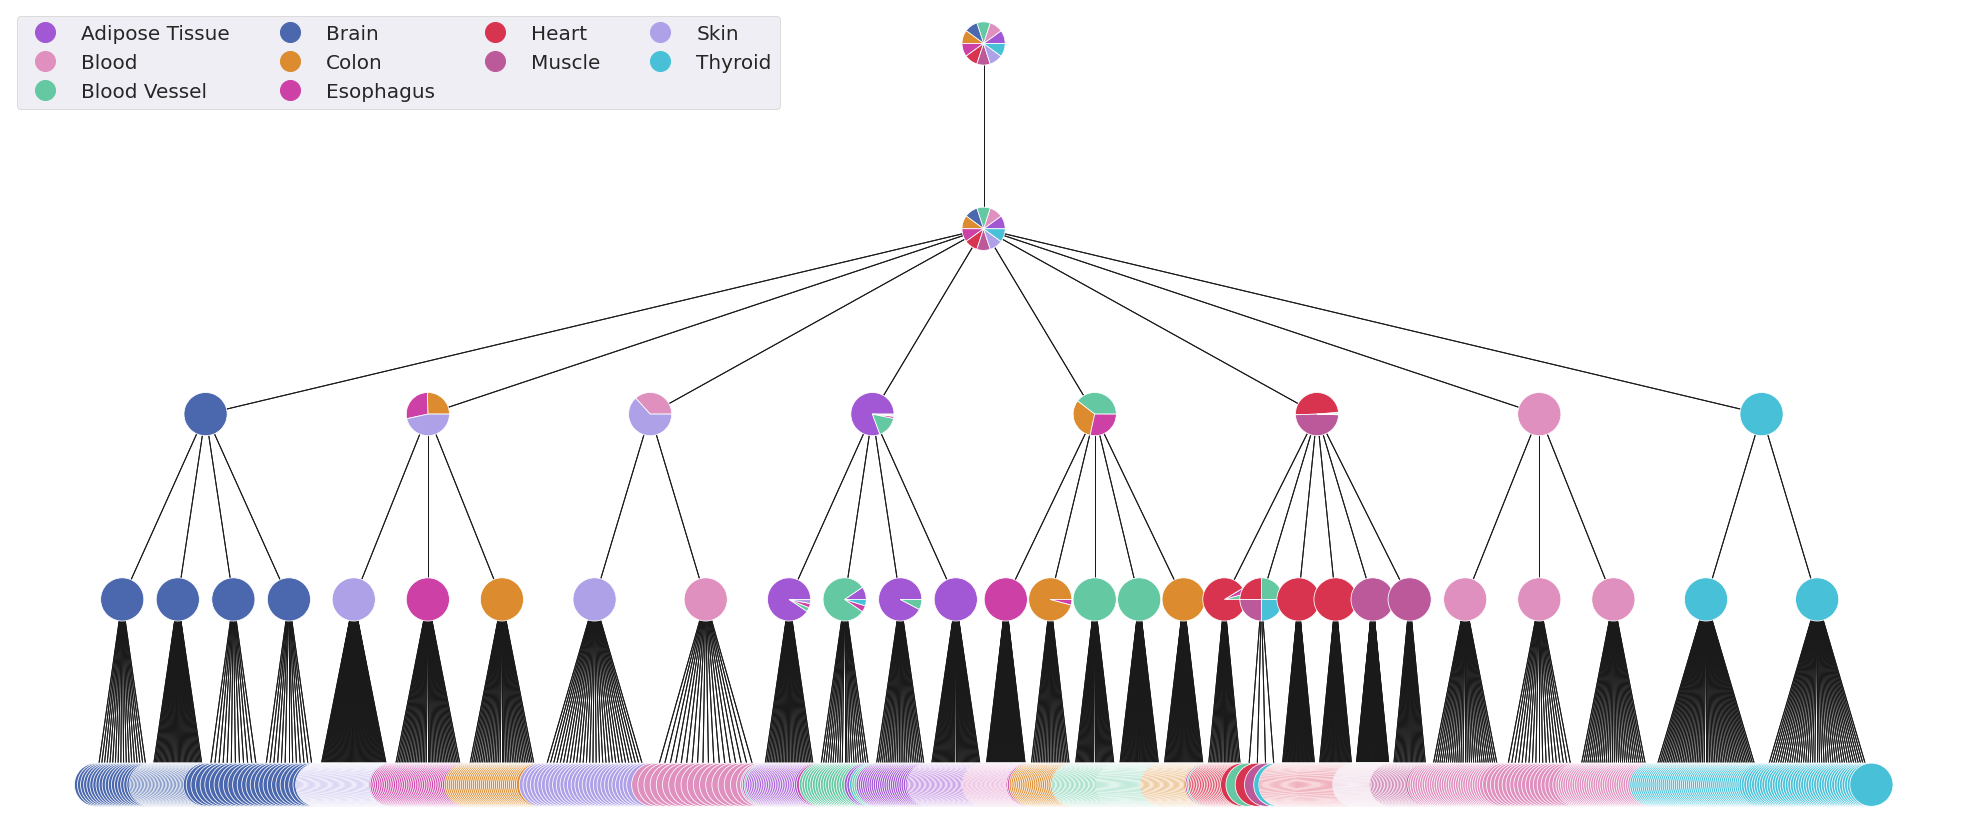

In [18]:
pos = hierarchy_pos(hierarchy, root=f"l{L}_1")
fig, ax = plt.subplots(figsize=(35,15))

nx.draw(hierarchy, pos=pos, ax=ax)
nx.draw_networkx_nodes(hierarchy,pos)
nx.draw_networkx_edges(hierarchy, pos=pos, ax=ax)
#nx.draw_networkx_labels(hierarchy, pos=pos, ax=ax, font_size=25)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.05
p2=piesize/2.0
for n in hierarchy:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    fracs, colors = get_fracs(n)
    a.pie(fracs, colors=colors)
    
legend_elements = [Line2D([0], [0], 
                          marker='o', 
                          ms = 20,
                          lw = 0,
                          color=network_lut[label], 
                          label=label,
                          markerfacecolor=network_lut[label],
                          markersize=15) for label in np.sort(labels)]


# Put a legend to the right of the current axis
ax.legend(handles=legend_elements, fontsize=20, ncol=4, loc='upper left')
    
plt.show()
fig.savefig("cluster_network.pdf")

In [19]:
for tissue,color in network_lut.copy().items():
    color = network_lut[tissue]
    network_lut[tissue+"_healthy"] = color
    network_lut[tissue+"_tumor"] = [c*0.4 for c in sns.set_hls_values(color)]

In [20]:
network_lut

{'Adipose Tissue': '#a257d4',
 'Blood': '#e090bf',
 'Blood Vessel': '#64c9a3',
 'Brain': '#4b68ae',
 'Colon': '#dc8c2f',
 'Esophagus': '#cd41a7',
 'Heart': '#d9344f',
 'Muscle': '#bc599a',
 'Skin': '#afa1e8',
 'Thyroid': '#48c1d8',
 'Adipose Tissue_healthy': '#a257d4',
 'Adipose Tissue_tumor': [0.2541176470588234,
  0.13647058823529412,
  0.33254901960784317],
 'Blood_healthy': '#e090bf',
 'Blood_tumor': [0.35137254901960785, 0.22588235294117648, 0.2996078431372548],
 'Blood Vessel_healthy': '#64c9a3',
 'Blood Vessel_tumor': [0.15686274509803924,
  0.31529411764705884,
  0.25568627450980397],
 'Brain_healthy': '#4b68ae',
 'Brain_tumor': [0.1176470588235294, 0.16313725490196085, 0.2729411764705883],
 'Colon_healthy': '#dc8c2f',
 'Colon_tumor': [0.3450980392156863, 0.21960784313725493, 0.07372549019607844],
 'Esophagus_healthy': '#cd41a7',
 'Esophagus_tumor': [0.3215686274509804,
  0.10196078431372549,
  0.2619607843137254],
 'Heart_healthy': '#d9344f',
 'Heart_tumor': [0.340392156862745